## UBP x Paymaya project

### Aim: 


#### Background: 


*import libraries*

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import dask
import dask.dataframe as dd
import dask.bag as db

import networkx as nx
import igraph
import bokeh
import collections
import powerlaw 
import operator 

In [2]:
import warnings
warnings.filterwarnings("ignore")

pd.options.display.max_rows = 50
pd.options.display.max_columns = 50

*import data*

In [3]:
txn_df = pd.read_csv('./data/data.csv')

In [4]:
txn_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 960933 entries, 0 to 960932
Data columns (total 29 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   Unnamed: 0.1                   960933 non-null  int64  
 1   Unnamed: 0                     960933 non-null  int64  
 2   Unnamed: 0_x                   960933 non-null  int64  
 3   mcif                           960933 non-null  int64  
 4   alertid                        737146 non-null  object 
 5   tran_date                      960933 non-null  object 
 6   currency                       960933 non-null  object 
 7   source_name                    960933 non-null  object 
 8   target_name                    830862 non-null  object 
 9   TargetBank                     960933 non-null  object 
 10  txn_amount                     960933 non-null  float64
 11  target_acct                    960933 non-null  object 
 12  from_acct                     

levels 
<br> Level1 (one edge):
UBP to OtherUBP/ UBP to paymaya

Level 2 (two edges):
UBP to UBP to other NonUBP (gcash, paymaya, and nonubp) accounts (if applicable)

Level 3 (three edges or more):
UBP to UBP to UBP to other NonUBP (gcash, paymaya, and nonubp) accounts (if applicable)

In [5]:
txn_df['TargetBank'].unique()

array(['UBP', 'NonUBP', 'paymaya', 'Gcash'], dtype=object)

In [6]:
txn_df['TargetBank'].value_counts()

NonUBP     336636
Gcash      318001
UBP        293268
paymaya     13028
Name: TargetBank, dtype: int64

In [7]:
txn_df['TargetBank'].value_counts(normalize=True)

NonUBP     0.350322
Gcash      0.330929
UBP        0.305191
paymaya    0.013558
Name: TargetBank, dtype: float64

##### percentage of frauds in dataset

In [8]:
txn_df['response'].value_counts()

1    737146
0    223787
Name: response, dtype: int64

In [9]:
txn_df['response'].value_counts(normalize=True)

1    0.767115
0    0.232885
Name: response, dtype: float64

#### level 1: UBP to paymaya

In [10]:
paymaya_df = txn_df[txn_df['TargetBank']=='paymaya']

In [11]:
paymaya_df.head()

,Unnamed: 0.1,Unnamed: 0,Unnamed: 0_x,mcif,alertid,tran_date,currency,source_name,target_name,TargetBank,txn_amount,target_acct,from_acct,report_dt,Unnamed: 0_y,tenure,sameday_C_ATM_amt,sameday_D_ft_amt,sameday_D_ft_count,sameday_ft_Gcash_count,sameday_ft_OtherUBP_count,sameday_ft_NonUBP_count,sameday_ft_Gcash_amt,sameday_ft_OtherUBP_amt,sameday_ft_NonUBP_amt,sameday_Android_UBlogin_count,1day_C_ft_amt,2mon_C_others_count,response
2,2,2,25514,9972939,20201221CPC019972939,2020-12-21,PHP,personal savings,cedie atienza,paymaya,21878.35,fa0415580b7af2858e756256d4aedd26,109420139839,2020-12-21,42408,390.0,0.0,0.0,0,17,2,59,167872.71,25788.32,625086.18,6,43756.7,0,1
12,12,12,139501,9972939,20201221CPC019972939,2020-12-21,PHP,personal savings,mary grace d jayme,paymaya,15257.18,fa0415580b7af2858e756256d4aedd26,109420139839,2020-12-21,42408,390.0,0.0,0.0,0,17,2,59,167872.71,25788.32,625086.18,6,43756.7,0,1
25,25,25,340520,9972939,20201221CPC019972939,2020-12-21,PHP,personal savings,victoria bea lizarondo,paymaya,8963.12,fa0415580b7af2858e756256d4aedd26,109420139839,2020-12-21,42408,390.0,0.0,0.0,0,17,2,59,167872.71,25788.32,625086.18,6,43756.7,0,1
52,52,52,647483,9972939,20201221CPC019972939,2020-12-21,PHP,personal savings,mary grace magtulis,paymaya,1106.32,fa0415580b7af2858e756256d4aedd26,109420139839,2020-12-21,42408,390.0,0.0,0.0,0,17,2,59,167872.71,25788.32,625086.18,6,43756.7,0,1
79,79,79,915862,9972939,20201221CPC019972939,2020-12-21,PHP,personal savings,justin deauna,paymaya,15337.64,fa0415580b7af2858e756256d4aedd26,109420139839,2020-12-21,42408,390.0,0.0,0.0,0,17,2,59,167872.71,25788.32,625086.18,6,43756.7,0,1


In [12]:
# check duplicates
paymaya_df[paymaya_df.duplicated()]

,Unnamed: 0.1,Unnamed: 0,Unnamed: 0_x,mcif,alertid,tran_date,currency,source_name,target_name,TargetBank,txn_amount,target_acct,from_acct,report_dt,Unnamed: 0_y,tenure,sameday_C_ATM_amt,sameday_D_ft_amt,sameday_D_ft_count,sameday_ft_Gcash_count,sameday_ft_OtherUBP_count,sameday_ft_NonUBP_count,sameday_ft_Gcash_amt,sameday_ft_OtherUBP_amt,sameday_ft_NonUBP_amt,sameday_Android_UBlogin_count,1day_C_ft_amt,2mon_C_others_count,response


In [13]:
# check NaN
paymaya_df.isnull().sum()

Unnamed: 0.1                        0
Unnamed: 0                          0
Unnamed: 0_x                        0
mcif                                0
alertid                          5581
tran_date                           0
currency                            0
source_name                         0
target_name                         0
TargetBank                          0
txn_amount                          0
target_acct                         0
from_acct                           0
report_dt                           0
Unnamed: 0_y                        0
tenure                              0
sameday_C_ATM_amt                   0
sameday_D_ft_amt                    0
sameday_D_ft_count                  0
sameday_ft_Gcash_count              0
sameday_ft_OtherUBP_count           0
sameday_ft_NonUBP_count             0
sameday_ft_Gcash_amt                0
sameday_ft_OtherUBP_amt             0
sameday_ft_NonUBP_amt               0
sameday_Android_UBlogin_count       0
1day_C_ft_am

In [14]:
paymaya_df[paymaya_df['source_name']=='personal savings']

,Unnamed: 0.1,Unnamed: 0,Unnamed: 0_x,mcif,alertid,tran_date,currency,source_name,target_name,TargetBank,txn_amount,target_acct,from_acct,report_dt,Unnamed: 0_y,tenure,sameday_C_ATM_amt,sameday_D_ft_amt,sameday_D_ft_count,sameday_ft_Gcash_count,sameday_ft_OtherUBP_count,sameday_ft_NonUBP_count,sameday_ft_Gcash_amt,sameday_ft_OtherUBP_amt,sameday_ft_NonUBP_amt,sameday_Android_UBlogin_count,1day_C_ft_amt,2mon_C_others_count,response
2,2,2,25514,9972939,20201221CPC019972939,2020-12-21,PHP,personal savings,cedie atienza,paymaya,21878.35,fa0415580b7af2858e756256d4aedd26,109420139839,2020-12-21,42408,390.0,0.0,0.0,0,17,2,59,167872.71,25788.32,625086.18,6,43756.70,0,1
12,12,12,139501,9972939,20201221CPC019972939,2020-12-21,PHP,personal savings,mary grace d jayme,paymaya,15257.18,fa0415580b7af2858e756256d4aedd26,109420139839,2020-12-21,42408,390.0,0.0,0.0,0,17,2,59,167872.71,25788.32,625086.18,6,43756.70,0,1
25,25,25,340520,9972939,20201221CPC019972939,2020-12-21,PHP,personal savings,victoria bea lizarondo,paymaya,8963.12,fa0415580b7af2858e756256d4aedd26,109420139839,2020-12-21,42408,390.0,0.0,0.0,0,17,2,59,167872.71,25788.32,625086.18,6,43756.70,0,1
52,52,52,647483,9972939,20201221CPC019972939,2020-12-21,PHP,personal savings,mary grace magtulis,paymaya,1106.32,fa0415580b7af2858e756256d4aedd26,109420139839,2020-12-21,42408,390.0,0.0,0.0,0,17,2,59,167872.71,25788.32,625086.18,6,43756.70,0,1
79,79,79,915862,9972939,20201221CPC019972939,2020-12-21,PHP,personal savings,justin deauna,paymaya,15337.64,fa0415580b7af2858e756256d4aedd26,109420139839,2020-12-21,42408,390.0,0.0,0.0,0,17,2,59,167872.71,25788.32,625086.18,6,43756.70,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
925234,925234,925234,598406,11841065,20210308MRM0111841065,2021-03-08,PHP,personal savings,rowel dismaya,paymaya,10000.00,e6763d6e5a713d743b2631b1fe71e1d6,109420781873,2021-03-08,3237,324.0,85000.0,59880.0,5,0,0,4,0.00,0.00,25380.00,1,115000.00,243,1
929055,929055,929055,539551,14266255,20210301MRM0314266255,2021-03-01,PHP,personal savings,abegail frayres,paymaya,8931.00,3d59f77aef13d29bd67be01ce4ef07e0,109423882223,2021-03-01,30861,77.0,131000.0,201500.0,3,0,1,1,0.00,138500.00,15069.00,4,543435.00,3,1
940861,940861,940861,693345,12440784,20210111MRM0112440784,2021-01-11,PHP,personal savings,gcm smart retailer,paymaya,10000.00,f87b94d268bc0efb8d8aa073eaca65bd,109421870702,2021-01-11,9748,163.0,34000.0,20000.0,1,0,1,1,0.00,10000.00,19000.00,0,43000.00,233,1
952876,952876,952876,819855,10418376,NaN,2021-01-30,PHP,personal savings,john francis piraman,paymaya,190.99,e967822e3674894c157f31b208a2b41e,109420224222,2021-01-30,54405,404.0,0.0,0.0,0,0,0,0,0.00,0.00,0.00,1,2033.96,0,0


##### percentage of fraud in paymaya txn

In [15]:
paymaya_df['response'].value_counts(normalize=True)

1    0.571615
0    0.428385
Name: response, dtype: float64

In [16]:
paymaya_df = paymaya_df[paymaya_df['source_name']!=paymaya_df['target_name']]

In [17]:
paymaya_df.shape

(11729, 29)

##### Build graph
**define nodes/edges**

In [18]:
# define edges 
df_edges = paymaya_df[['source_name','target_name','txn_amount']]

# create network 
G_paymaya = nx.from_pandas_edgelist(df_edges, source = 'source_name', target = 'target_name', edge_attr = 'txn_amount', create_using=nx.DiGraph())


**Network statistics**

In [19]:
N = G_paymaya.order() #G.order(), gives number of nodes 
L = G_paymaya.size() #G.size(), gives number of edges

avg_deg = float(L) / N #calculate average degree

print("Nodes: ", N)
print("Edges: ", L)
print("Average degree: ", avg_deg)

Nodes:  9653
Edges:  6965
Average degree:  0.7215373459028281


**in-degree/out-degree**

In [20]:
# In-degree and Out-degree
in_degrees = G_paymaya.in_degree()  # dictionary node:degree
out_degrees = G_paymaya.out_degree()

# Example
print("Transactions in personal savings: %d" % in_degrees['personal savings']) #txn in personal savings
print("Transactions out personal savings: %d" % out_degrees['personal savings']) #txn out of personal savings

Transactions in personal savings: 0
Transactions out personal savings: 252


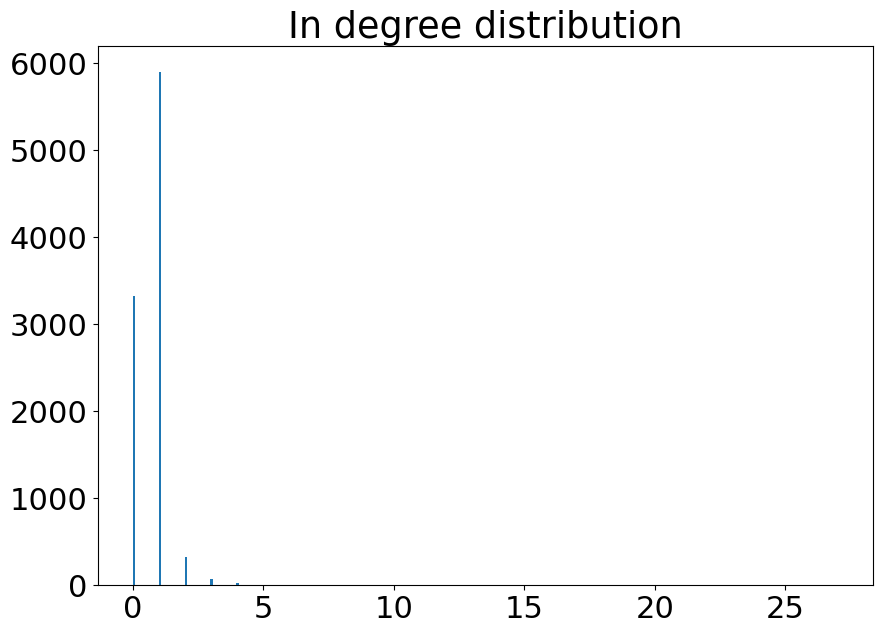

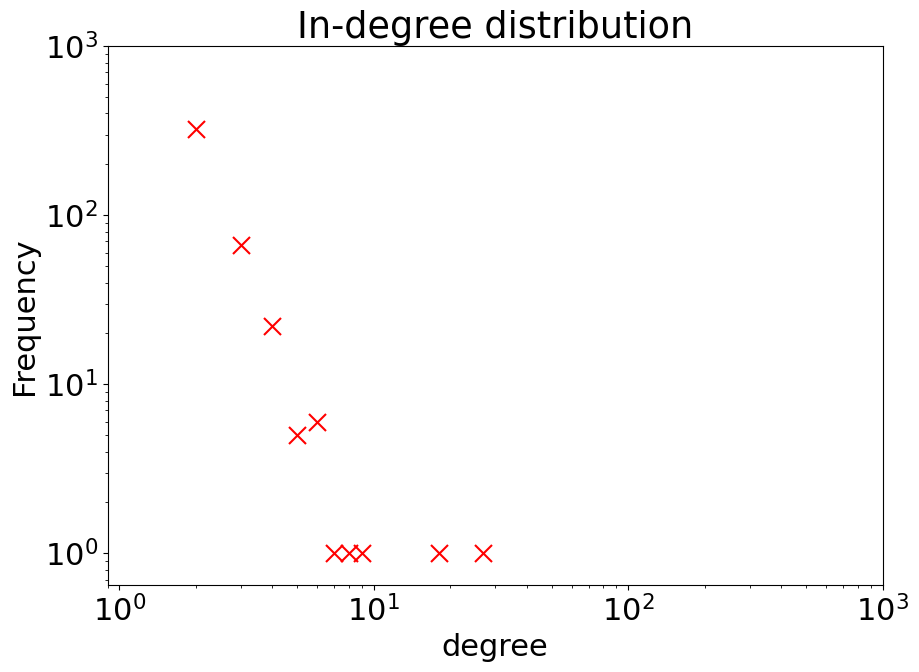

Calculating best minimal value for power law fit


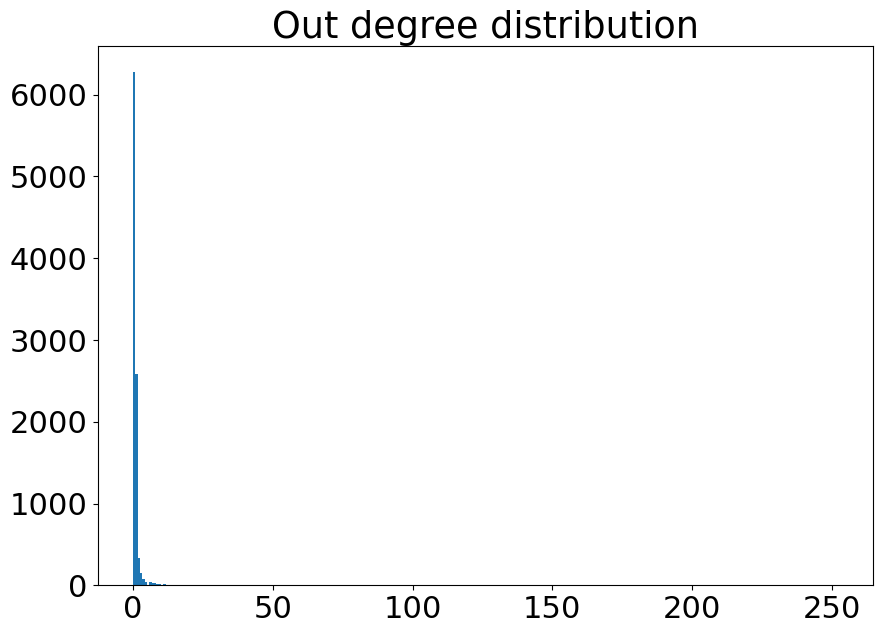

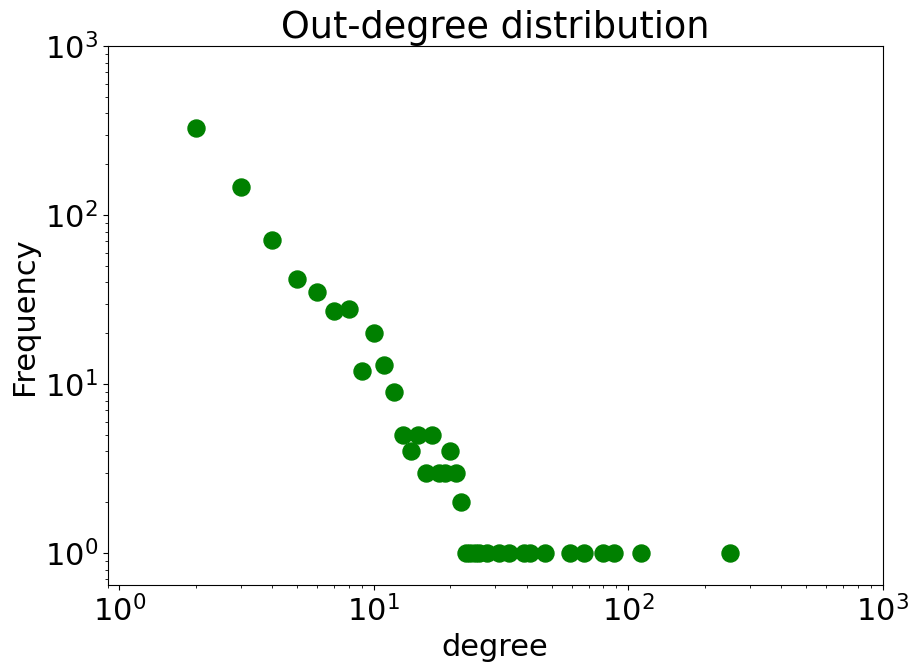

In [21]:
fig_size= [10,7]
plt.rcParams.update({'font.size': 22, "figure.figsize": fig_size})

#Histogram of in-degrees
plt.hist(dict(in_degrees()).values(), bins=300, density=False)
plt.title('In degree distribution')
plt.show()

#Plot log-log of in-degree distribution
plt.yscale('log') 
plt.xscale('log') 

in_degree_counts = dict(collections.Counter(dict(in_degrees()).values()))

#Create scatter plot with degree on x-axis and counts on y-axis
plt.scatter(in_degree_counts.keys(), in_degree_counts.values(), c='r', marker='x', s=150)
plt.xlim((.9, 1e3)) #set x axis limits
plt.ylim((0, 1e3)) #set y axis limits
plt.xlabel('degree')
plt.ylabel('Frequency')
plt.title('In-degree distribution')
plt.show()

data = np.array(list(in_degree_counts.values()),dtype=np.float32)
fit = powerlaw.Fit(data)

#Histogram of out-degrees
plt.hist(dict(out_degrees()).values(), bins=300, density=False)
plt.title('Out degree distribution')
plt.show()

#Plot log-log of in-degree distribution
plt.yscale('log') 
plt.xscale('log') 

out_degree_counts = dict(collections.Counter(dict(out_degrees()).values())) 

#Create scatter plot with degree on x-axis and counts on y-axis 
plt.scatter(out_degree_counts.keys(), out_degree_counts.values(), c='g', marker='o', s=150)
plt.xlim((.9, 1e3)) #set x axis limits
plt.ylim((0, 1e3)) #set y axis limits
plt.xlabel('degree')
plt.ylabel('Frequency')
plt.title('Out-degree distribution')
plt.show()

##### Path Lengths
<br> path length - max number of transactions from one account to the other 
<br> Network diameter is the longest shortest path between any two nodes in the network.

In [22]:
if not 'avg_path_length' in globals(): 
    max_path_length = 0
    total = 0.0
    for n in G_paymaya: #iterate over all nodes
        path_length=nx.single_source_shortest_path_length(G_paymaya, n) 
        total += sum(path_length.values()) #total of all shortest paths from n
    
        if max(path_length.values()) > max_path_length: #keep track of longest shortest path 
            max_path_length = max(path_length.values())         
    avg_path_length = total / (N*(N - 1)) #calculate average.
    
print("Average path length %f" % (avg_path_length)) 
print("Network Diameter or max path length %d" % (max_path_length)) 


Average path length 0.000081
Network Diameter or max path length 3


##### Centrality
**Which account has the highest centrality?**
<br> Betweenness centrality - which account lies on most txn routes
<br> Closeness centrality - which account has the shortest number of transfers to all other account 
<br> Degree centrality - the (general) number of accounts it is connected to
<br> Eigenvector centrality - which account is connected to other important networks
<br> Pagerank - ranks the nodes in the graph based on the structure of the incoming links

**betweenness centrality**

Betweenness mean: 0.000000
1: ('maria', 4.5087864008818673e-07)
2: ('jannica mae sta ana', 4.2940822865541595e-07)
3: ('number', 2.898505543424058e-07)
4: ('ian vincent dedase', 2.7911534862602033e-07)
5: ('joel frayres', 2.5764493719324955e-07)
6: ('marielle', 1.9323370289493716e-07)
7: ('grant kimmuel endaya', 1.9323370289493716e-07)
8: ('digipay', 1.2882246859662477e-07)
9: ('marc darell gomez', 1.1808726288023938e-07)
10: ('vincent', 9.661685144746858e-08)


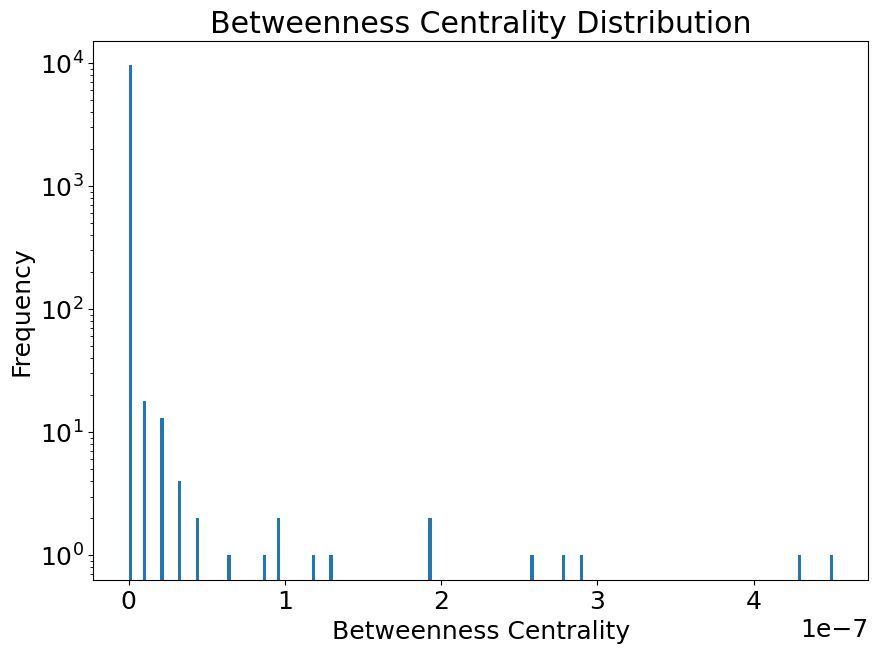

In [23]:
if not 'bet_cen' in globals(): #only calculate this if its not been calculated before
    bet_cen = nx.betweenness_centrality(G_paymaya)

#Histogram of betweenness
print("Betweenness mean: %f" % (np.array(list(bet_cen.values())).mean()))

#get a list of acct sorted by betweenness
acct_sorted_by_betweenness = sorted(bet_cen.items(), key=operator.itemgetter(1), reverse=True)

for x in range(10): #print top 10 acct by betweenness
    print(str(x+1)+ ": " + str(acct_sorted_by_betweenness[x]))

#plt.bar(center, hist)
plt.rcParams.update({'font.size': 18})

plt.hist(bet_cen.values(), bins=200, density=False) 
plt.xlabel('Betweenness Centrality')
plt.ylabel('Frequency')
plt.yscale('log')
plt.title('Betweenness Centrality Distribution')
plt.show()

**closeness centrality**

Closeness mean: 0.000076
1: ('number', 0.0027973476999585576)
2: ('paymaya', 0.0018648984666390386)
3: ('mary jessa dosdos', 0.0014768488867121273)
4: ('john', 0.0009324492333195193)
5: ('cheryl cao', 0.0008954472796163637)
6: ('anna', 0.0007252382925818483)
7: ('marvin', 0.0006216328222130128)
8: ('mark', 0.0006216328222130128)
9: ('jenny', 0.0006216328222130128)
10: ('michael', 0.0006216328222130128)


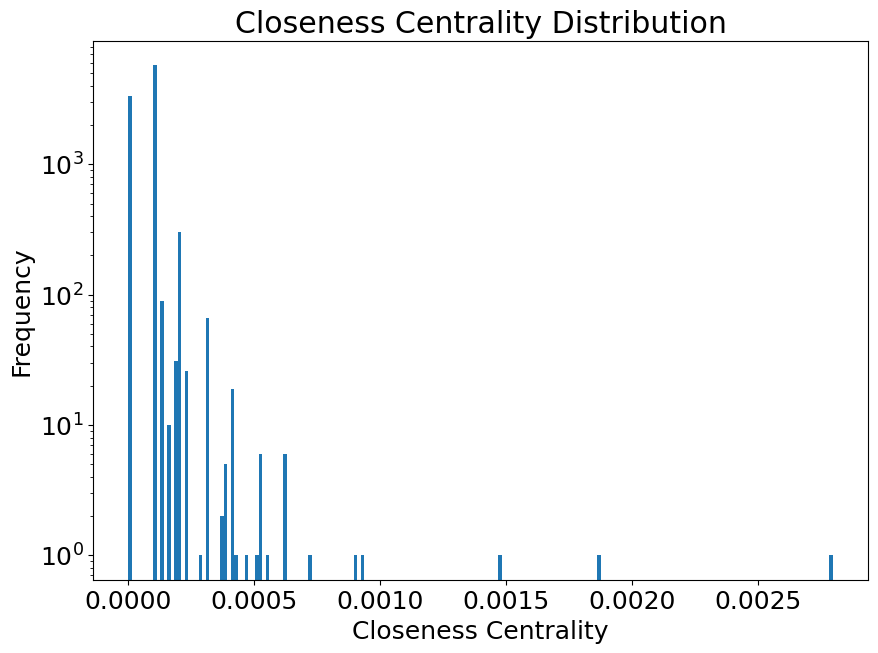

In [24]:
if not 'clo_cen' in globals(): 
    clo_cen = nx.closeness_centrality(G_paymaya)

#Histogram of closeness
print("Closeness mean: %f" % (np.array(list(clo_cen.values())).mean()))

#get a list of acct sorted by closeness
acct_sorted_by_closeness = sorted(clo_cen.items(), key=operator.itemgetter(1), reverse=True)

for x in range(10): #print top 10 acct by closeness
    print(str(x+1)+ ": " + str(acct_sorted_by_closeness[x]))

#plt.bar(center, hist)
plt.rcParams.update({'font.size': 18})

plt.hist(clo_cen.values(), bins=200, density=False) 
plt.xlabel('Closeness Centrality')
plt.ylabel('Frequency')
plt.yscale('log')
plt.title('Closeness Centrality Distribution')
plt.show()

**degree centrality**

Degree mean: 0.000150
1: ('personal savings', 0.026108578532946538)
2: ('randy villamar', 0.011603812681309573)
3: ('playeveryday debit', 0.009117281392457521)
4: ('merlyn mojica', 0.008288437629506838)
5: ('michael mendoza ', 0.006941566514711977)
6: ('me m', 0.006112722751761293)
7: ('mara quijano', 0.004869457107335267)
8: ('mark lucio', 0.004247824285122255)
9: ('golden', 0.0040406133443845835)
10: ('john jerome tamba', 0.003522585992540406)


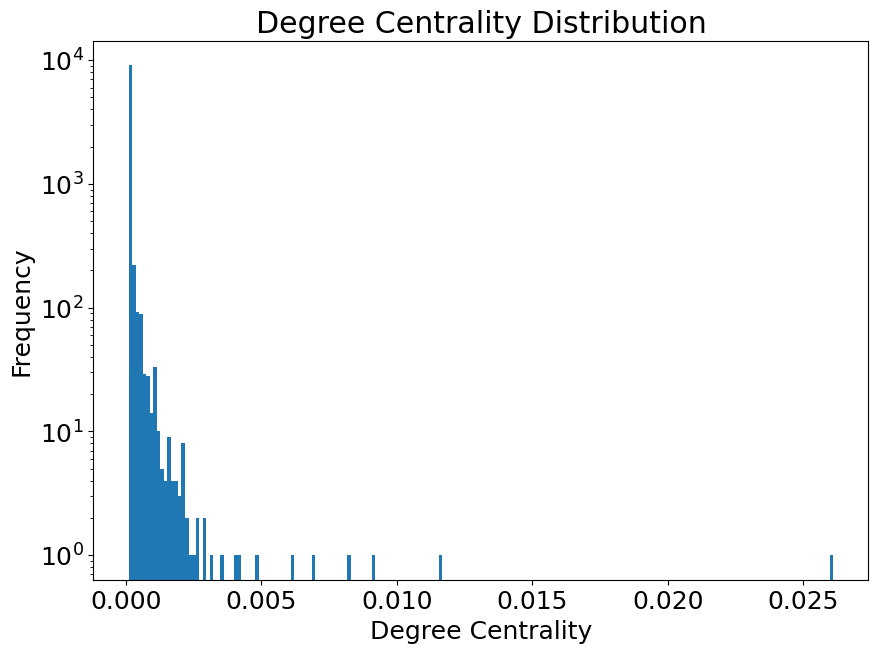

In [25]:
if not 'deg_cen' in globals(): 
    deg_cen = nx.degree_centrality(G_paymaya)
    
#Histogram of degrees
print("Degree mean: %f" % (np.array(list(deg_cen.values())).mean()))

#get a list of acct sorted by degree
acct_sorted_by_degree = sorted(deg_cen.items(), key=operator.itemgetter(1), reverse=True)

for x in range(10): #print top 10 acct by degree
    print(str(x+1)+ ": " + str(acct_sorted_by_degree[x]))

#plt.bar(center, hist)
plt.rcParams.update({'font.size': 18})

plt.hist(deg_cen.values(), bins=200, density=False) 
plt.xlabel('Degree Centrality')
plt.ylabel('Frequency')
plt.yscale('log')
plt.title('Degree Centrality Distribution')
plt.show()

**eigenvector centrality**

Eigenvector mean: 0.000569
1: ('angelito isidro', 0.3429974172511522)
2: ('richell b', 0.171499308323355)
3: ('fritz laudemer pedrialva', 0.171499308323355)
4: ('jannica mae sta ana', 0.17149873588456602)
5: ('randolf magdaong', 0.17149873588456602)
6: ('warren briones', 0.17149873588456602)
7: ('gerly dela cruz', 0.17149873588456602)
8: ('jesus manlapat', 0.1714987086255761)
9: ('rodelio bernardo', 0.1714987086255761)
10: ('mark jayson duldulao', 0.1714987086255761)


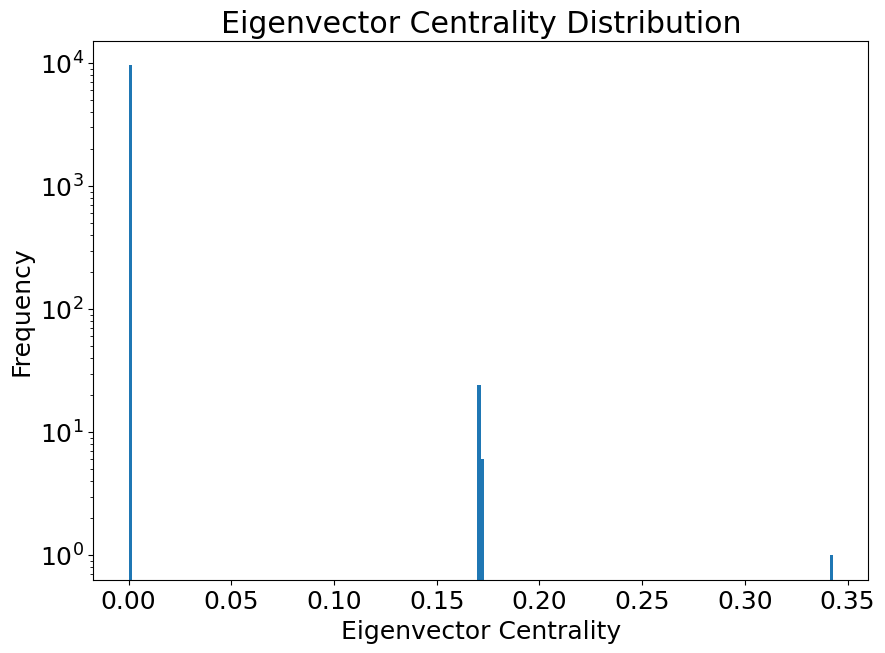

In [26]:
if not 'eig_cen' in globals(): 
    eig_cen = nx.eigenvector_centrality(G_paymaya, max_iter=200)

#Histogram of eigenvector_centrality
print("Eigenvector mean: %f" % (np.array(list(eig_cen.values())).mean()))

#get a list of acct sorted by betweenness
acct_sorted_by_eigenvector = sorted(eig_cen.items(), key=operator.itemgetter(1), reverse=True)

for x in range(10): #print top 10 acct by eigenvector
    print(str(x+1)+ ": " + str(acct_sorted_by_eigenvector[x]))

#plt.bar(center, hist)
plt.rcParams.update({'font.size': 18})

plt.hist(eig_cen.values(), bins=200, density=False) 
plt.xlabel('Eigenvector Centrality')
plt.ylabel('Frequency')
plt.yscale('log')
plt.title('Eigenvector Centrality Distribution')
plt.show()

**pagerank**

Pagerank mean: 0.000104
1: ('number', 0.0009241215496138983)
2: ('mary jessa dosdos', 0.0008874511499206807)
3: ('paymaya', 0.0008556450502609352)
4: ('maria', 0.00036672046310661915)
5: ('katherine rivera', 0.00032637638000745527)
6: ('ruth', 0.0003095663453828036)
7: ('john', 0.0003095572037883027)
8: ('grace', 0.00029835965563303587)
9: ('jonathan', 0.0002654441306414829)
10: ('margie mapanao', 0.0002650280059242564)


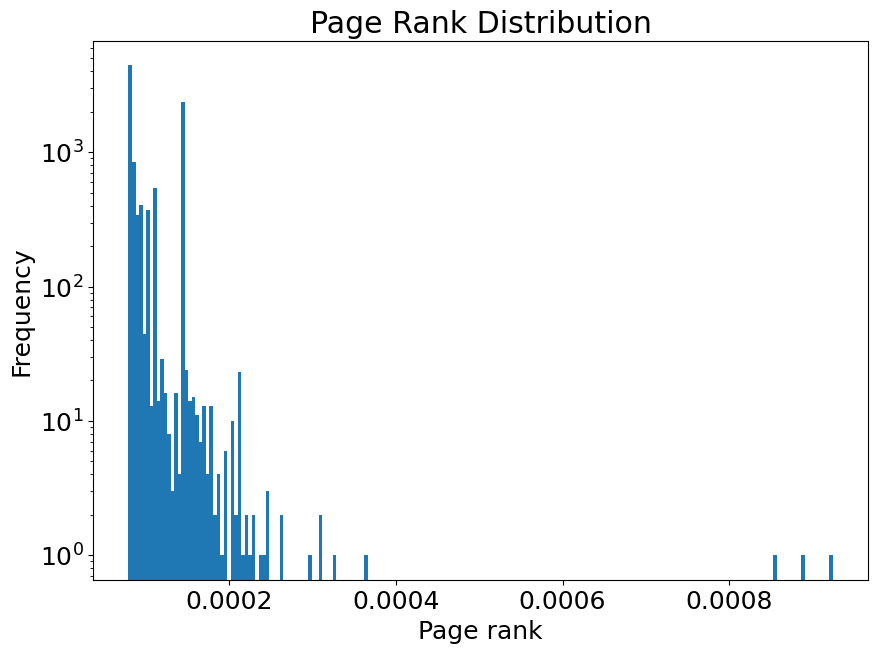

In [27]:
if not 'pagerank_cen' in globals(): 
    pagerank_cen = nx.pagerank(G_paymaya, max_iter=200)

#Histogram of pagerank
print("Pagerank mean: %f" % (np.array(list(pagerank_cen.values())).mean()))

#get a list of acct sorted by betweenness
acct_sorted_by_pagerank = sorted(pagerank_cen.items(), key=operator.itemgetter(1), reverse=True)

for x in range(10): #print top 10 acct by pagerank
    print(str(x+1)+ ": " + str(acct_sorted_by_pagerank[x]))

#plt.bar(center, hist)
plt.rcParams.update({'font.size': 18})

plt.hist(pagerank_cen.values(), bins=200, density=False) 
plt.xlabel('Page rank')
plt.ylabel('Frequency')
plt.yscale('log')
plt.title('Page Rank Distribution')
plt.show()


##### Correlation of centrality measures to fraud

##### dask

In [28]:
nodes_info_dict = {
    'betweenness_centrality': nx.betweenness_centrality,
    'closeness_centrality': nx.closeness_centrality,
    'eigenvector_centrality': nx.eigenvector_centrality_numpy, # otherwise, cannot converge without _numpy
    'pagerank': nx.pagerank 
}

columns_with_node_infos = ['degree'] + list(nodes_info_dict.keys())

nodes_info = pd.DataFrame.from_dict(dict(nx.degree(G_paymaya)), orient='index').rename(columns = {0 : 'degree'}).reset_index()

# convert to dask
nodes_info = dd.from_pandas(nodes_info, npartitions=20)


In [29]:
columns_with_node_infos

['degree',
 'betweenness_centrality',
 'closeness_centrality',
 'eigenvector_centrality',
 'pagerank']

In [30]:
nodes_info.head()

,index,degree
0,personal savings,252
1,cedie atienza,1
2,mary grace d jayme,1
3,victoria bea lizarondo,1
4,mary grace magtulis,1


In [31]:
len(nodes_info)

9653

In [32]:
# my_bag = db.from_sequence(G_paymaya, npartitions=4)
# df = my_bag.to_dataframe()
# my_bag.to_delayed(True)

In [33]:
def make_df(df,info):
    return pd.DataFrame.from_dict(df, orient='index').rename(columns = {0 : info}).reset_index()


In [34]:
%%time
for info, fun in nodes_info_dict.items():
    delayed_1 = dask.delayed(fun)(G_paymaya)
    delayed_2 = dask.delayed(make_df)(delayed_1,info)
    temp = dd.from_delayed(delayed_2)
    nodes_info = nodes_info.merge(temp, on='index')

nodes_info = nodes_info.rename(columns = {'index': 'name'})
nodes_info # still in dask df

CPU times: total: 1min 4s
Wall time: 1min 23s


,name,degree,betweenness_centrality,closeness_centrality,eigenvector_centrality,pagerank
npartitions=20,,,,,,
,object,int64,float64,float64,float64,float64
,...,...,...,...,...,...
...,...,...,...,...,...,...
,...,...,...,...,...,...
,...,...,...,...,...,...


In [35]:
nodes_info.compute()

,name,degree,betweenness_centrality,closeness_centrality,eigenvector_centrality,pagerank
0,personal savings,252,0.0,0.000000,3.724872e-18,0.000080
1,cedie atienza,1,0.0,0.000104,2.026417e-18,0.000080
2,mary grace d jayme,1,0.0,0.000104,-2.097989e-19,0.000080
3,victoria bea lizarondo,1,0.0,0.000104,-4.276163e-18,0.000080
4,mary grace magtulis,1,0.0,0.000104,1.887411e-18,0.000080
...,...,...,...,...,...,...
471,hannah jemimah r prado,1,0.0,0.000104,-6.004114e-19,0.000147
472,maria abigail gagarin serrano,1,0.0,0.000000,-4.903534e-18,0.000080
473,abby serrano,1,0.0,0.000104,4.137987e-19,0.000147
474,noli rom ligsa,1,0.0,0.000000,1.022215e-19,0.000080


In [36]:
paymaya_dask = dd.from_pandas(paymaya_df[['source_name','target_name','tran_date','TargetBank', 'txn_amount','response']],npartitions=20)

# adding graph features to df
# merge on source_name
lvl1pay_cen = paymaya_dask.merge(nodes_info, left_on = 'source_name', right_on='name', how='left').drop('name', axis=1)
lvl1pay_cen = lvl1pay_cen.rename(columns = {k:'source_'+k for k in columns_with_node_infos})

# merge on target_name
lvl1pay_cen = lvl1pay_cen.merge(nodes_info, left_on = 'target_name', 
                           right_on='name', how='left').drop('name', axis=1)
lvl1pay_cen = lvl1pay_cen.rename(columns = {k:'target_'+k for k in columns_with_node_infos})


In [37]:
# test for monotonic correlation with fraud
cen_corr = lvl1pay_cen.corr(method='pearson').abs()
cen_corr.loc[cen_corr['response']>=0.05,['response']].sort_values(by=['response'],ascending=False)

,response
npartitions=1,
txn_amount,float64
target_pagerank,...


In [38]:
cen_corr.compute()

,txn_amount,response,source_degree,source_betweenness_centrality,source_closeness_centrality,source_eigenvector_centrality,source_pagerank,target_degree,target_betweenness_centrality,target_closeness_centrality,target_eigenvector_centrality,target_pagerank
txn_amount,1.000000,0.126987,0.016703,0.017921,0.008922,0.031217,0.012236,0.054024,0.049544,0.051397,0.031565,0.063580
response,0.126987,1.000000,0.161995,0.039317,0.020733,0.007558,0.014112,0.123112,0.099596,0.122005,0.003168,0.021502
source_degree,0.016703,0.161995,1.000000,0.021094,0.025160,0.009773,0.019202,0.000630,0.004512,0.000741,0.010131,0.085074
source_betweenness_centrality,0.017921,0.039317,0.021094,1.000000,0.709800,0.650567,0.498845,0.075741,0.110982,0.067601,0.603218,0.019323
source_closeness_centrality,0.008922,0.020733,0.025160,0.709800,1.000000,0.301147,0.883140,0.029533,0.044775,0.056580,0.278516,0.037882
source_eigenvector_centrality,0.031217,0.007558,0.009773,0.650567,0.301147,1.000000,0.027620,0.051772,0.124853,0.003208,0.924847,0.029976
source_pagerank,0.012236,0.014112,0.019202,0.498845,0.883140,0.027620,1.000000,0.018241,0.017662,0.057736,0.024937,0.050961
target_degree,0.054024,0.123112,0.000630,0.075741,0.029533,0.051772,0.018241,1.000000,0.923325,0.978132,0.053917,0.941073
target_betweenness_centrality,0.049544,0.099596,0.004512,0.110982,0.044775,0.124853,0.017662,0.923325,1.000000,0.858943,0.124143,0.824319
target_closeness_centrality,0.051397,0.122005,0.000741,0.067601,0.056580,0.003208,0.057736,0.978132,0.858943,1.000000,0.001202,0.963064


CPU times: total: 1min 37s
Wall time: 1min 35s


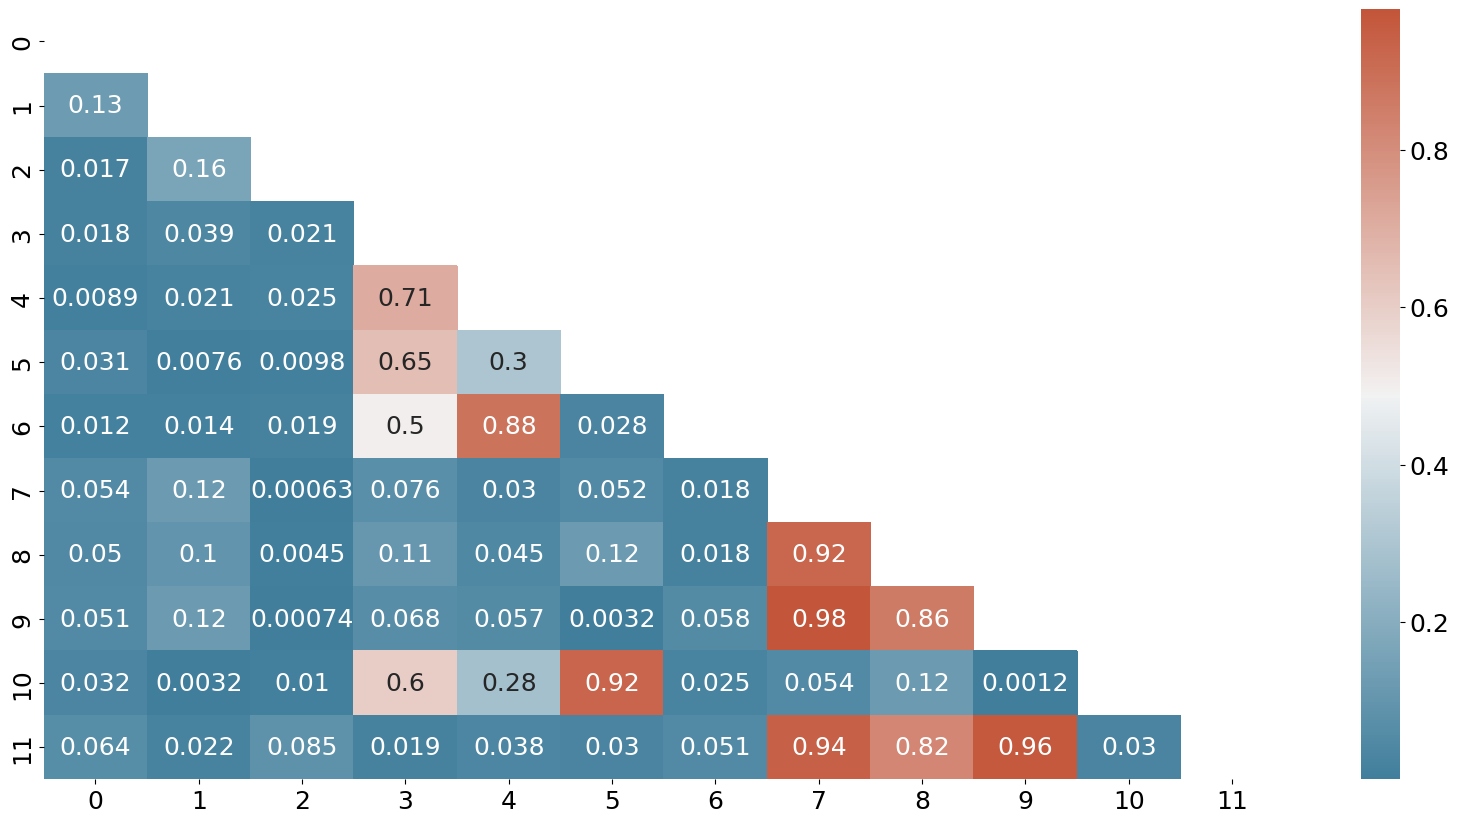

In [39]:
%%time
# plotting correlation 
plt.figure(figsize=(20,10))
mask = np.triu(np.ones_like(np.abs(lvl1pay_cen.corr()), dtype=bool));

cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(np.abs(lvl1pay_cen.corr(method='pearson')),
            cmap=cmap,
            mask=mask,
            annot=True,
            fmt='.2g'
           );

##### pandas

In [40]:
# define edges 
df_edges = paymaya_df[['source_name','target_name','txn_amount']]

# create network 
G_pay = nx.from_pandas_edgelist(df_edges, source = 'source_name', target = 'target_name', edge_attr = 'txn_amount', create_using=nx.DiGraph())


In [41]:
nodes_info_dict = {
    'betweenness_centrality': nx.betweenness_centrality,
    'closeness_centrality': nx.closeness_centrality,
    'eigenvector_centrality': nx.eigenvector_centrality_numpy, # otherwise, cannot converge without _numpy
    'pagerank': nx.pagerank 
}

columns_with_node_infos = ['degree'] + list(nodes_info_dict.keys())

nodes_info = pd.DataFrame.from_dict(dict(nx.degree(G_pay)), orient='index').rename(columns = {0 : 'degree'}).reset_index()


In [42]:
G_pay.order() # number of nodes, should match below

9653

In [43]:
nodes_info # should match G.order()

,index,degree
0,personal savings,252
1,cedie atienza,1
2,mary grace d jayme,1
3,victoria bea lizarondo,1
4,mary grace magtulis,1
...,...,...
9648,hannah jemimah r prado,1
9649,maria abigail gagarin serrano,1
9650,abby serrano,1
9651,noli rom ligsa,1


In [44]:
%%time
# computing graph features for each node
for info, fun in nodes_info_dict.items():
    temp = pd.DataFrame.from_dict(fun(G_pay), orient='index').rename(columns = {0 : info}).reset_index()
    nodes_info = nodes_info.merge(temp, on='index')

nodes_info = nodes_info.rename(columns = {'index': 'name'})
nodes_info

CPU times: total: 42.4 s
Wall time: 44.1 s


,name,degree,betweenness_centrality,closeness_centrality,eigenvector_centrality,pagerank
0,personal savings,252,0.0,0.000000,3.443607e-21,0.000080
1,cedie atienza,1,0.0,0.000104,7.508655e-19,0.000080
2,mary grace d jayme,1,0.0,0.000104,-3.111916e-19,0.000080
3,victoria bea lizarondo,1,0.0,0.000104,8.505467e-19,0.000080
4,mary grace magtulis,1,0.0,0.000104,2.380273e-18,0.000080
...,...,...,...,...,...,...
9648,hannah jemimah r prado,1,0.0,0.000104,9.733493e-19,0.000147
9649,maria abigail gagarin serrano,1,0.0,0.000000,-1.772211e-18,0.000080
9650,abby serrano,1,0.0,0.000104,-2.135421e-18,0.000147
9651,noli rom ligsa,1,0.0,0.000000,1.612835e-19,0.000080


In [45]:
# adding graph features to df
# merge on source_name
lvl1pay_cen = paymaya_df[['source_name','target_name','tran_date','TargetBank', 'txn_amount','response']].merge(nodes_info, left_on = 'source_name',  
                           right_on='name', how='left').drop('name', axis=1)
lvl1pay_cen.rename(columns = {k:'source_'+k for k in columns_with_node_infos}, inplace = True)

# merge on target_name
lvl1pay_cen = lvl1pay_cen.merge(nodes_info, left_on = 'target_name', 
                           right_on='name', how='left').drop('name', axis=1)
lvl1pay_cen.rename(columns = {k:'target_'+k for k in columns_with_node_infos}, inplace = True)
                
lvl1pay_cen

,source_name,target_name,tran_date,TargetBank,txn_amount,response,source_degree,source_betweenness_centrality,source_closeness_centrality,source_eigenvector_centrality,source_pagerank,target_degree,target_betweenness_centrality,target_closeness_centrality,target_eigenvector_centrality,target_pagerank
0,personal savings,cedie atienza,2020-12-21,paymaya,21878.35,1,252,0.0,0.0,3.443607e-21,0.00008,1,0.0,0.000104,7.508655e-19,0.000080
1,personal savings,mary grace d jayme,2020-12-21,paymaya,15257.18,1,252,0.0,0.0,3.443607e-21,0.00008,1,0.0,0.000104,-3.111916e-19,0.000080
2,personal savings,victoria bea lizarondo,2020-12-21,paymaya,8963.12,1,252,0.0,0.0,3.443607e-21,0.00008,1,0.0,0.000104,8.505467e-19,0.000080
3,personal savings,mary grace magtulis,2020-12-21,paymaya,1106.32,1,252,0.0,0.0,3.443607e-21,0.00008,1,0.0,0.000104,2.380273e-18,0.000080
4,personal savings,justin deauna,2020-12-21,paymaya,15337.64,1,252,0.0,0.0,3.443607e-21,0.00008,1,0.0,0.000104,-2.724293e-18,0.000080
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11724,"gabatbat, alfredo christian, bautista",alfredo christian gabatbat,2020-09-19,paymaya,500.00,0,1,0.0,0.0,-2.283973e-18,0.00008,1,0.0,0.000104,-1.787495e-18,0.000147
11725,"sioson, jay, santos",jay sioson,2020-12-17,paymaya,100.00,0,1,0.0,0.0,-1.201840e-18,0.00008,1,0.0,0.000104,-1.995002e-18,0.000147
11726,hannah jemimah prado,hannah jemimah r prado,2021-02-02,paymaya,500.00,0,1,0.0,0.0,-1.748375e-20,0.00008,1,0.0,0.000104,9.733493e-19,0.000147
11727,maria abigail gagarin serrano,abby serrano,2020-12-02,paymaya,1135.00,0,1,0.0,0.0,-1.772211e-18,0.00008,1,0.0,0.000104,-2.135421e-18,0.000147


In [46]:
lvl1pay_cen.isnull().sum()

source_name                      0
target_name                      0
tran_date                        0
TargetBank                       0
txn_amount                       0
response                         0
source_degree                    0
source_betweenness_centrality    0
source_closeness_centrality      0
source_eigenvector_centrality    0
source_pagerank                  0
target_degree                    0
target_betweenness_centrality    0
target_closeness_centrality      0
target_eigenvector_centrality    0
target_pagerank                  0
dtype: int64

In [47]:
lvl1pay_cen.corr()

,txn_amount,response,source_degree,source_betweenness_centrality,source_closeness_centrality,source_eigenvector_centrality,source_pagerank,target_degree,target_betweenness_centrality,target_closeness_centrality,target_eigenvector_centrality,target_pagerank
txn_amount,1.000000,0.126987,-0.016703,-0.017921,-0.008922,-0.031217,0.012236,-0.054024,-0.049544,-0.051397,-0.031565,-0.063580
response,0.126987,1.000000,0.161995,0.039317,0.020733,0.007558,0.014112,0.123112,0.099596,0.122005,0.003168,0.021502
source_degree,-0.016703,0.161995,1.000000,-0.021094,-0.025160,-0.009773,-0.019202,-0.000630,-0.004512,0.000741,-0.010131,-0.085074
source_betweenness_centrality,-0.017921,0.039317,-0.021094,1.000000,0.709800,0.650567,0.498845,0.075741,0.110982,0.067601,0.603218,0.019323
source_closeness_centrality,-0.008922,0.020733,-0.025160,0.709800,1.000000,0.301147,0.883140,0.029533,0.044775,0.056580,0.278516,0.037882
source_eigenvector_centrality,-0.031217,0.007558,-0.009773,0.650567,0.301147,1.000000,0.027620,0.051772,0.124853,-0.003208,0.924847,-0.029976
source_pagerank,0.012236,0.014112,-0.019202,0.498845,0.883140,0.027620,1.000000,0.018241,0.017662,0.057736,0.024937,0.050961
target_degree,-0.054024,0.123112,-0.000630,0.075741,0.029533,0.051772,0.018241,1.000000,0.923325,0.978132,0.053917,0.941073
target_betweenness_centrality,-0.049544,0.099596,-0.004512,0.110982,0.044775,0.124853,0.017662,0.923325,1.000000,0.858943,0.124143,0.824319
target_closeness_centrality,-0.051397,0.122005,0.000741,0.067601,0.056580,-0.003208,0.057736,0.978132,0.858943,1.000000,-0.001202,0.963064


CPU times: total: 344 ms
Wall time: 400 ms


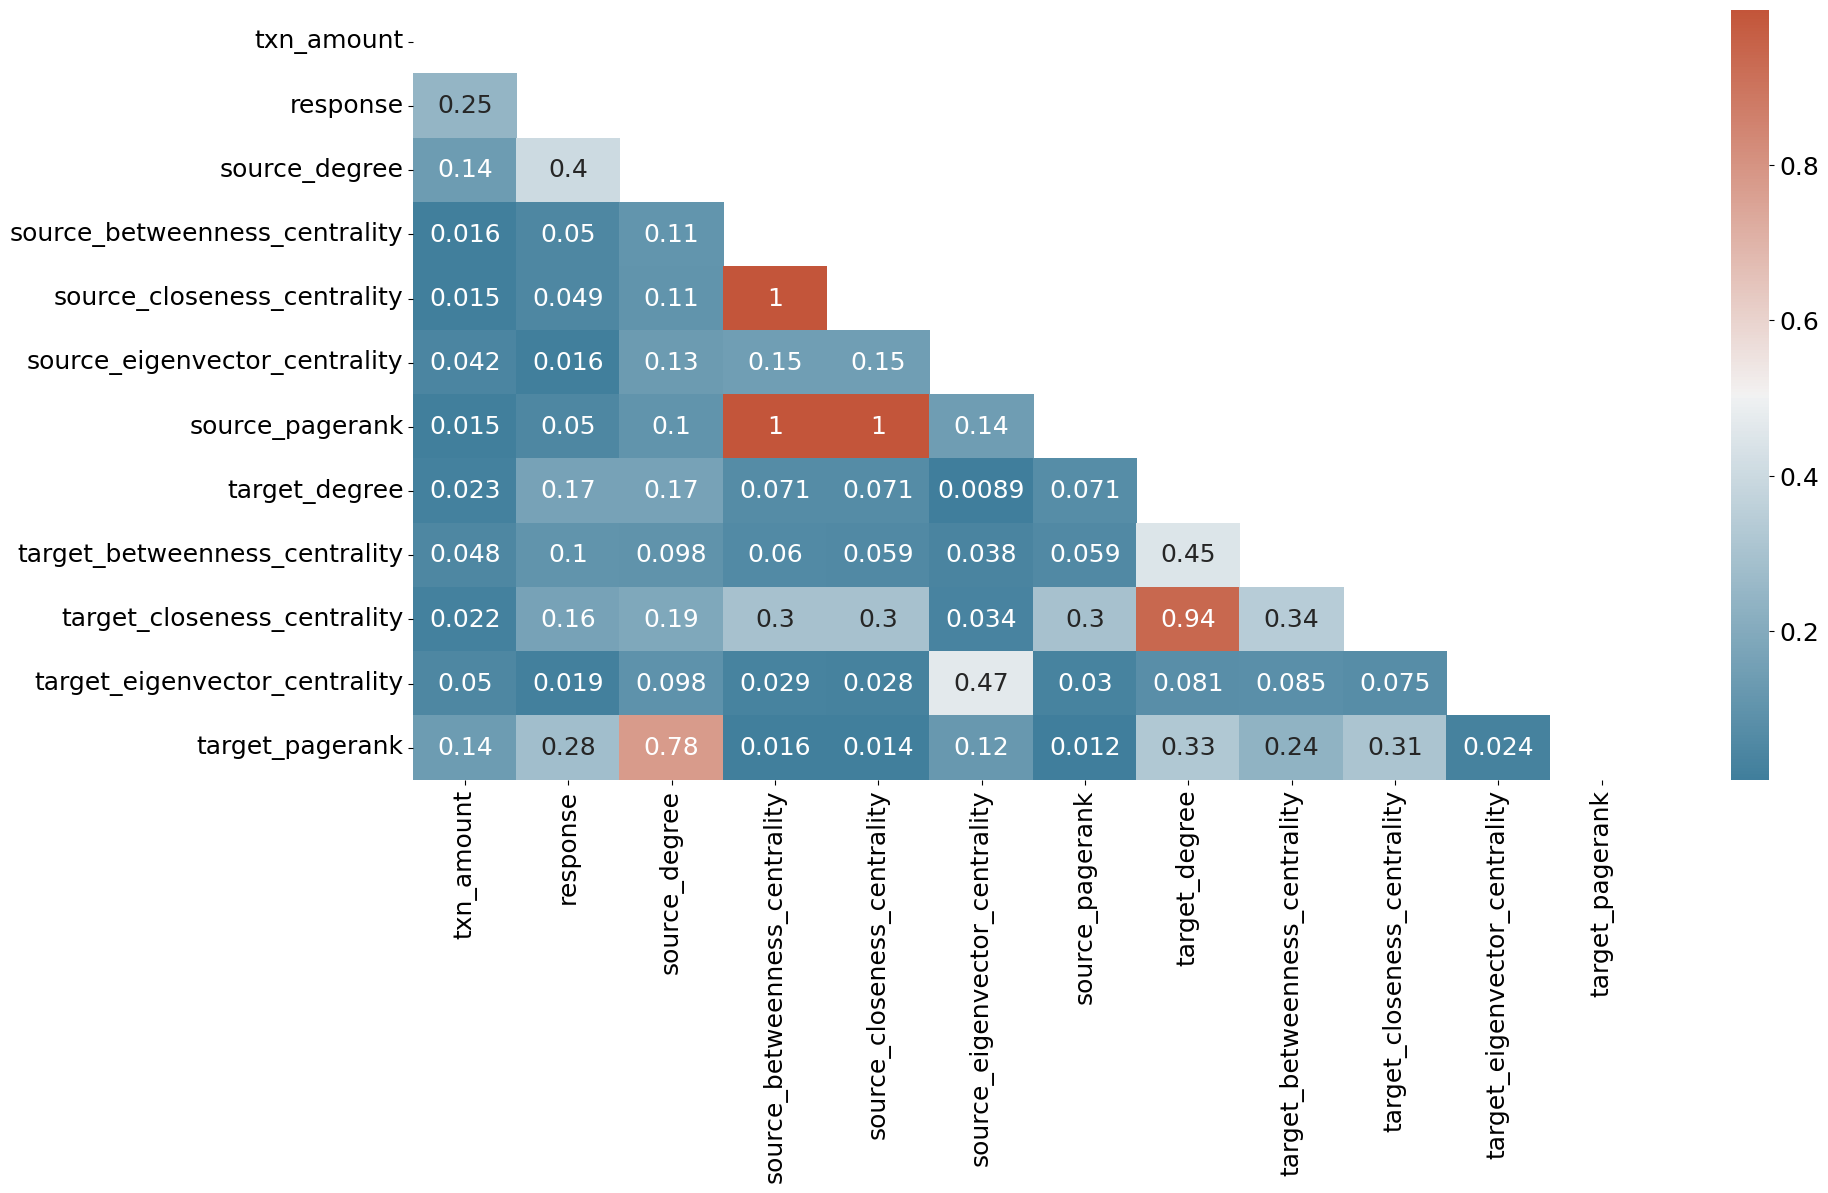

In [48]:
%%time
# plotting correlation 
plt.figure(figsize=(20,10))
mask = np.triu(np.ones_like(np.abs(lvl1pay_cen.corr()), dtype=bool));

cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(np.abs(lvl1pay_cen.corr(method='spearman')),
            cmap=cmap,
            mask=mask,
            annot=True,
            fmt='.2g'
           );

In [49]:
# test for monotonic correlation with fraud
cen_corr = lvl1pay_cen.corr(method='spearman').abs()
cen_corr.loc[cen_corr['response']>=0.05,['response']].sort_values(by=['response'],ascending=False)

,response
response,1.000000
source_degree,0.400966
target_pagerank,0.282633
txn_amount,0.248672
target_degree,0.166639
target_closeness_centrality,0.164479
target_betweenness_centrality,0.103042


##### igraph

In [50]:
# df includes anything that can be nodes, edges, attributes
df = paymaya_df[['source_name','target_name','txn_amount','response']]

# define nodes to only first column, other columns attributes
df_nodes = pd.melt(paymaya_df,
        id_vars=['response'],
        value_vars=['source_name','target_name'],
        value_name='nodes'
)[['nodes']].drop_duplicates(subset='nodes')

# create network 
G_ig_paymaya = igraph.Graph.DataFrame(df, directed=True, vertices=df_nodes, use_vids=False)

**Network statistics**

In [51]:
N = G_ig_paymaya.vcount() # nr of nodes
L = G_ig_paymaya.ecount() # nr of edges

avg_deg = float(L) / N #calculate average degree

print("Nodes: ", N)
print("Edges: ", L)
print("Average degree: ", avg_deg)
print("Max degree: ", G_ig_paymaya.maxdegree())

Nodes:  9653
Edges:  11729
Average degree:  1.2150626748161193
Max degree:  472


**in-degree/out-degree**

**Path Lengths**
<br> path length - max number of transactions from one account to the other 
<br> Network diameter is the longest shortest path between any two nodes in the network.

In [52]:
print("Average path length %f" % (G_ig_paymaya.average_path_length())) 
print("Network Diameter or max path length %f" % (G_ig_paymaya.diameter())) 


Average path length 1.043203
Network Diameter or max path length 3.000000


In [53]:
G_ig_paymaya.path_length_hist()

**Centrality**
<br> **Which account has the highest centrality?**
<br> Betweenness centrality - which account lies on most txn routes
<br> Closeness centrality - which account has the shortest number of transfers to all other account 
<br> Degree centrality - the (general) number of accounts it is connected to
<br> Eigenvector centrality - which account is connected to other important networks
<br> Pagerank - ranks the nodes in the graph based on the structure of the incoming links


In [54]:
%%time
g_degree = G_ig_paymaya.degree()
g_closeness = G_ig_paymaya.closeness()
g_betweenness = G_ig_paymaya.betweenness()
g_eigenvector = G_ig_paymaya.eigenvector_centrality()
g_pagerank = G_ig_paymaya.pagerank()

df_ig = pd.DataFrame(columns=['name', 'degree','closeness','betweenness','eigenvector','pagerank'])

for idx, node in enumerate(G_ig_paymaya.vs):
#     print(idx,node['name'])
    df_ig.loc[idx] = [node['name'], g_degree[idx], g_closeness[idx], g_betweenness[idx], g_eigenvector[idx], g_pagerank[idx]]

CPU times: total: 29.6 s
Wall time: 31.3 s


**Correlation of centrality measures to fraud**

In [55]:
df_ig

,name,degree,closeness,betweenness,eigenvector,pagerank
0,personal savings,472,0.201834,0.0,1.847412e-18,0.000080
1,felcris joy viado,2,1.000000,0.0,1.847412e-18,0.000080
2,helen pastrana,2,1.000000,0.0,1.847412e-18,0.000080
3,eden mae macalisang,17,0.128762,0.0,1.847412e-18,0.000080
4,michael mendoza,155,0.188147,0.0,1.847412e-18,0.000080
...,...,...,...,...,...,...
9648,ednalyn mortel,1,1.000000,0.0,-0.000000e+00,0.000147
9649,alfredo christian gabatbat,1,1.000000,0.0,0.000000e+00,0.000147
9650,hannah jemimah r prado,1,1.000000,0.0,9.237058e-19,0.000147
9651,abby serrano,1,1.000000,0.0,0.000000e+00,0.000147


In [56]:
# adding graph features to df
# merge on source_name
lvl1pay_cen = paymaya_df[['source_name','target_name','tran_date','TargetBank', 'txn_amount','response']].merge(df_ig, left_on = 'source_name',  
                           right_on='name', how='left').drop('name', axis=1)
lvl1pay_cen.rename(columns = {col:'source_'+col for col in df_ig.columns.drop(['name'])}, inplace = True)

# merge on target_name
lvl1pay_cen = lvl1pay_cen.merge(df_ig, left_on = 'target_name', 
                           right_on='name', how='left').drop('name', axis=1)
lvl1pay_cen.rename(columns = {col:'target_'+col for col in df_ig.columns.drop(['name'])}, inplace = True)
                
lvl1pay_cen

,source_name,target_name,tran_date,TargetBank,txn_amount,response,source_degree,source_closeness,source_betweenness,source_eigenvector,source_pagerank,target_degree,target_closeness,target_betweenness,target_eigenvector,target_pagerank
0,personal savings,cedie atienza,2020-12-21,paymaya,21878.35,1,472,0.201834,0.0,1.847412e-18,0.00008,10,0.167951,0.0,-0.000000e+00,0.000081
1,personal savings,mary grace d jayme,2020-12-21,paymaya,15257.18,1,472,0.201834,0.0,1.847412e-18,0.00008,6,0.167951,0.0,0.000000e+00,0.000081
2,personal savings,victoria bea lizarondo,2020-12-21,paymaya,8963.12,1,472,0.201834,0.0,1.847412e-18,0.00008,11,0.167951,0.0,0.000000e+00,0.000081
3,personal savings,mary grace magtulis,2020-12-21,paymaya,1106.32,1,472,0.201834,0.0,1.847412e-18,0.00008,11,0.167951,0.0,0.000000e+00,0.000081
4,personal savings,justin deauna,2020-12-21,paymaya,15337.64,1,472,0.201834,0.0,1.847412e-18,0.00008,7,0.167951,0.0,-0.000000e+00,0.000081
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11724,"gabatbat, alfredo christian, bautista",alfredo christian gabatbat,2020-09-19,paymaya,500.00,0,1,1.000000,0.0,1.847412e-18,0.00008,1,1.000000,0.0,0.000000e+00,0.000147
11725,"sioson, jay, santos",jay sioson,2020-12-17,paymaya,100.00,0,2,1.000000,0.0,1.847412e-18,0.00008,2,1.000000,0.0,-0.000000e+00,0.000147
11726,hannah jemimah prado,hannah jemimah r prado,2021-02-02,paymaya,500.00,0,1,1.000000,0.0,1.847412e-18,0.00008,1,1.000000,0.0,9.237058e-19,0.000147
11727,maria abigail gagarin serrano,abby serrano,2020-12-02,paymaya,1135.00,0,1,1.000000,0.0,1.847412e-18,0.00008,1,1.000000,0.0,0.000000e+00,0.000147


In [57]:
lvl1pay_cen.corr()

,txn_amount,response,source_degree,source_closeness,source_betweenness,source_eigenvector,source_pagerank,target_degree,target_closeness,target_betweenness,target_eigenvector,target_pagerank
txn_amount,1.000000,0.126987,-0.031329,-0.001888,-0.017921,-0.028571,0.008375,-0.051711,-0.058282,-0.049544,-0.030750,-0.061775
response,0.126987,1.000000,0.220262,-0.343405,0.039317,-0.029270,0.002916,0.140812,-0.435624,0.099596,0.013615,0.039493
source_degree,-0.031329,0.220262,1.000000,-0.416270,0.010954,-0.001962,-0.001446,0.134561,-0.406341,0.098887,-0.000679,0.022022
source_closeness,-0.001888,-0.343405,-0.416270,1.000000,-0.104395,-0.001314,-0.060787,-0.205945,0.901573,-0.166899,-0.007249,-0.100449
source_betweenness,-0.017921,0.039317,0.010954,-0.104395,1.000000,0.658137,0.473562,0.073624,-0.104076,0.110982,0.510205,0.027864
source_eigenvector,-0.028571,-0.029270,-0.001962,-0.001314,0.658137,1.000000,0.078537,-0.000448,-0.013856,0.076449,0.679341,-0.025198
source_pagerank,0.008375,0.002916,-0.001446,-0.060787,0.473562,0.078537,1.000000,0.011616,-0.065780,0.008900,0.046474,0.045136
target_degree,-0.051711,0.140812,0.134561,-0.205945,0.073624,-0.000448,0.011616,1.000000,-0.174466,0.907008,0.016954,0.930513
target_closeness,-0.058282,-0.435624,-0.406341,0.901573,-0.104076,-0.013856,-0.065780,-0.174466,1.000000,-0.132439,-0.003874,-0.022116
target_betweenness,-0.049544,0.099596,0.098887,-0.166899,0.110982,0.076449,0.008900,0.907008,-0.132439,1.000000,0.214751,0.835971


CPU times: total: 328 ms
Wall time: 413 ms


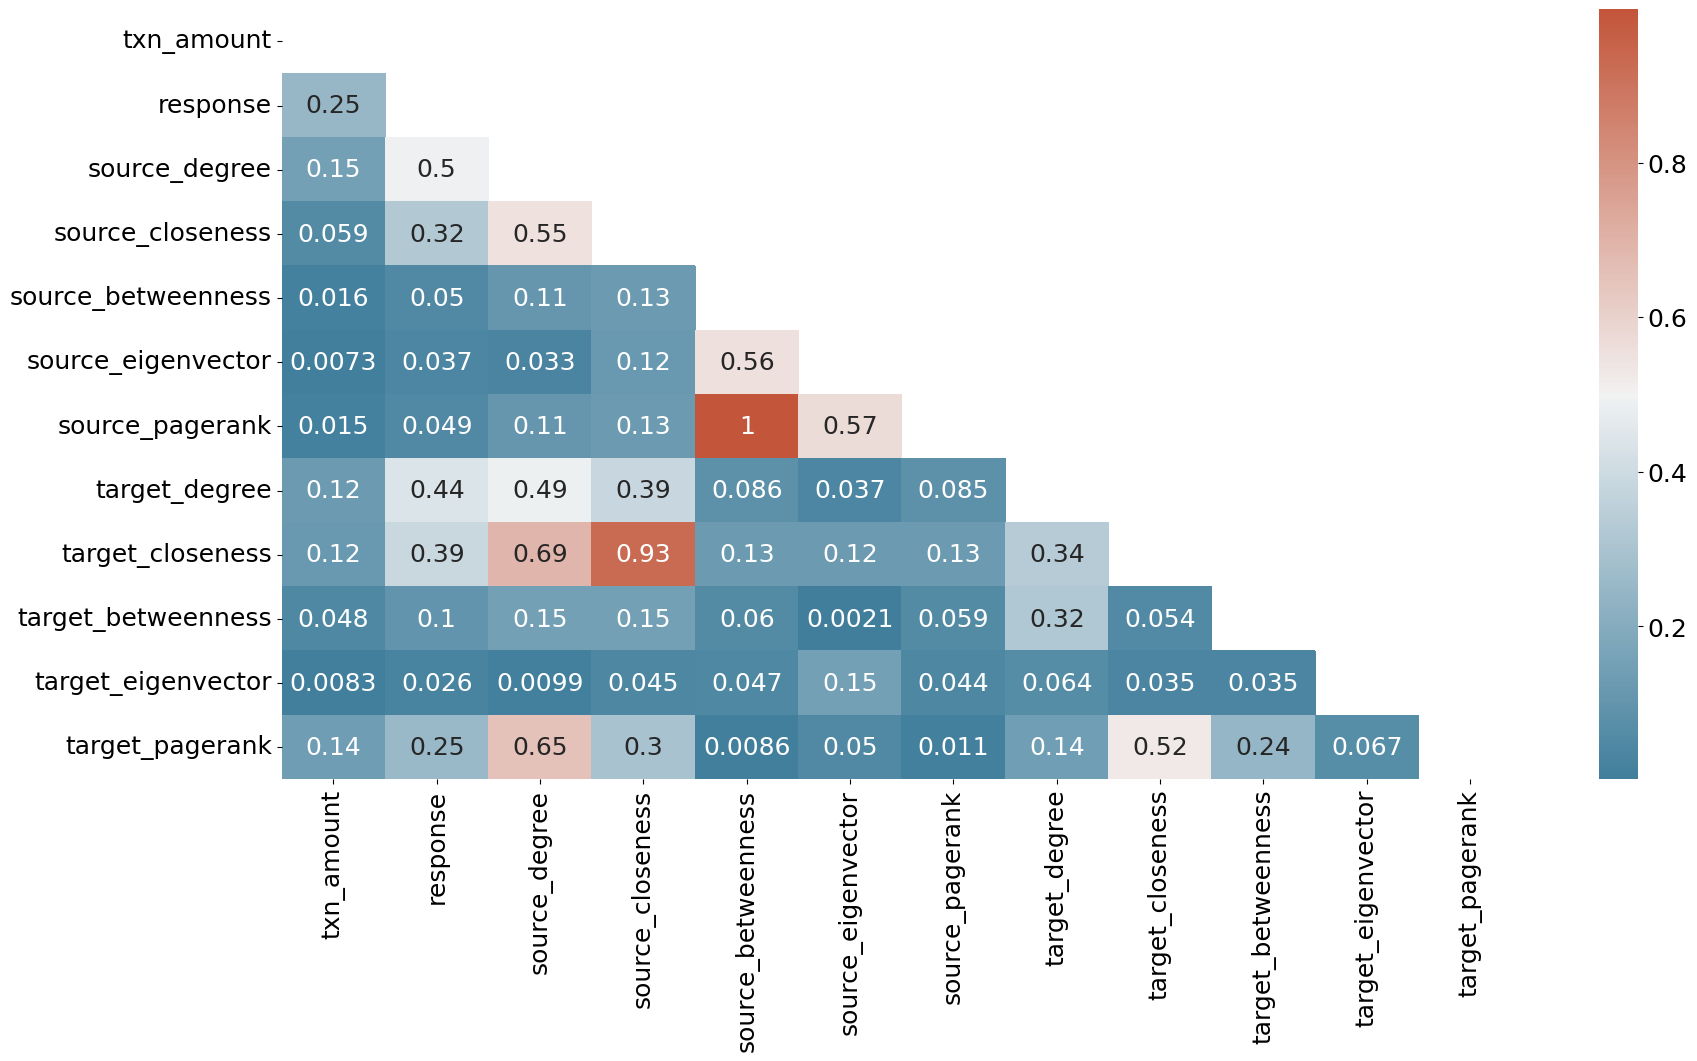

In [58]:
%%time
# plotting correlation 
plt.figure(figsize=(20,10))
mask = np.triu(np.ones_like(np.abs(lvl1pay_cen.corr()), dtype=bool));

cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(np.abs(lvl1pay_cen.corr(method='spearman')),
            cmap=cmap,
            mask=mask,
            annot=True,
            fmt='.2g'
           );

In [59]:
# test for monotonic correlation with fraud
cen_corr = lvl1pay_cen.corr(method='spearman').abs()
cen_corr.loc[cen_corr['response']>=0.05,['response']].sort_values(by=['response'],ascending=False)

,response
response,1.000000
source_degree,0.495578
target_degree,0.439575
target_closeness,0.389837
source_closeness,0.323293
target_pagerank,0.251886
txn_amount,0.248672
target_betweenness,0.103043


#### Separate fraud/not fraud network for comparison

#####  Only fraud

**Build graph**
<br> **define nodes/edges**

In [60]:
lvl1pay_fraud = paymaya_df[paymaya_df['response']==1]
lvl1pay_fraud

,Unnamed: 0.1,Unnamed: 0,Unnamed: 0_x,mcif,alertid,tran_date,currency,source_name,target_name,TargetBank,txn_amount,target_acct,from_acct,report_dt,Unnamed: 0_y,tenure,sameday_C_ATM_amt,sameday_D_ft_amt,sameday_D_ft_count,sameday_ft_Gcash_count,sameday_ft_OtherUBP_count,sameday_ft_NonUBP_count,sameday_ft_Gcash_amt,sameday_ft_OtherUBP_amt,sameday_ft_NonUBP_amt,sameday_Android_UBlogin_count,1day_C_ft_amt,2mon_C_others_count,response
2,2,2,25514,9972939,20201221CPC019972939,2020-12-21,PHP,personal savings,cedie atienza,paymaya,21878.35,fa0415580b7af2858e756256d4aedd26,109420139839,2020-12-21,42408,390.0,0.0,0.0,0,17,2,59,167872.71,25788.32,625086.18,6,43756.7,0,1
12,12,12,139501,9972939,20201221CPC019972939,2020-12-21,PHP,personal savings,mary grace d jayme,paymaya,15257.18,fa0415580b7af2858e756256d4aedd26,109420139839,2020-12-21,42408,390.0,0.0,0.0,0,17,2,59,167872.71,25788.32,625086.18,6,43756.7,0,1
25,25,25,340520,9972939,20201221CPC019972939,2020-12-21,PHP,personal savings,victoria bea lizarondo,paymaya,8963.12,fa0415580b7af2858e756256d4aedd26,109420139839,2020-12-21,42408,390.0,0.0,0.0,0,17,2,59,167872.71,25788.32,625086.18,6,43756.7,0,1
52,52,52,647483,9972939,20201221CPC019972939,2020-12-21,PHP,personal savings,mary grace magtulis,paymaya,1106.32,fa0415580b7af2858e756256d4aedd26,109420139839,2020-12-21,42408,390.0,0.0,0.0,0,17,2,59,167872.71,25788.32,625086.18,6,43756.7,0,1
79,79,79,915862,9972939,20201221CPC019972939,2020-12-21,PHP,personal savings,justin deauna,paymaya,15337.64,fa0415580b7af2858e756256d4aedd26,109420139839,2020-12-21,42408,390.0,0.0,0.0,0,17,2,59,167872.71,25788.32,625086.18,6,43756.7,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
954430,954430,954430,845332,12320950,20201109MRM0112320950,2020-11-09,PHP,charles solo,charlie solo,paymaya,5000.00,665258d0d325062a1ad1dc620fb5671b,109421567077,2020-11-09,8364,117.0,0.0,54000.0,2,0,1,0,0.00,50000.00,0.00,3,126700.0,1,1
954432,954432,954432,845333,12320950,20201109HRTC0112320950,2020-11-09,PHP,charles solo,charlie solo,paymaya,5000.00,665258d0d325062a1ad1dc620fb5671b,109421567077,2020-11-09,8363,117.0,0.0,54000.0,2,0,1,0,0.00,50000.00,0.00,3,126700.0,1,1
959499,959499,959499,934315,12236380,20201116MRM0112236380,2020-11-16,PHP,dory y. cortez,dory cortez,paymaya,30000.00,9442539843470b71d911637fe40ce4d2,109421397482,2020-11-16,7751,133.0,95000.0,0.0,0,0,0,0,0.00,0.00,0.00,4,203271.0,1,1
959505,959505,959505,958722,14487732,20210220CPC0114487732,2021-02-20,PHP,ronel subrado,ronel subrado,paymaya,1000.00,8128fb208ac0d63711631d052e49100f,109424200966,2021-02-20,33269,43.0,0.0,0.0,0,0,0,0,0.00,0.00,0.00,3,0.0,23,1


In [61]:
# define edges 
df_edges = lvl1pay_fraud[['source_name','target_name','txn_amount']]

# create network 
G_fraud = nx.from_pandas_edgelist(df_edges, source = 'source_name', target = 'target_name', edge_attr = 'txn_amount', create_using=nx.DiGraph())


**Network statistics**

In [62]:
N_fraud = G_fraud.order() #G.order(), gives number of nodes 
L_fraud = G_fraud.size() #G.size(), gives number of edges

avg_deg_fraud = float(L_fraud) / N_fraud #calculate average degree

print("Nodes: ", N_fraud)
print("Edges: ", L_fraud)
print("Average degree: ", avg_deg_fraud)


Nodes:  3875
Edges:  3264
Average degree:  0.8423225806451613


**in-degree/out-degree**

In [63]:
# In-degree and Out-degree
in_degrees_fraud = G_fraud.in_degree()  # dictionary node:degree
out_degrees_fraud = G_fraud.out_degree()

# Example
print("Transactions in personal savings: %d" % in_degrees_fraud['personal savings']) #txn in personal savings
print("Transactions out personal savings: %d" % out_degrees_fraud['personal savings']) #txn out of personal savings


Transactions in personal savings: 0
Transactions out personal savings: 183


#####  Only not-fraud 

In [64]:
lvl1pay_nonfraud = paymaya_df[paymaya_df['response']==0]
lvl1pay_nonfraud

,Unnamed: 0.1,Unnamed: 0,Unnamed: 0_x,mcif,alertid,tran_date,currency,source_name,target_name,TargetBank,txn_amount,target_acct,from_acct,report_dt,Unnamed: 0_y,tenure,sameday_C_ATM_amt,sameday_D_ft_amt,sameday_D_ft_count,sameday_ft_Gcash_count,sameday_ft_OtherUBP_count,sameday_ft_NonUBP_count,sameday_ft_Gcash_amt,sameday_ft_OtherUBP_amt,sameday_ft_NonUBP_amt,sameday_Android_UBlogin_count,1day_C_ft_amt,2mon_C_others_count,response
1479,1479,1479,162186,11814510,NaN,2020-08-11,PHP,helen pastrana,sherylene paymaya number excel,paymaya,50.00,7cbd51f257d76086060893079e09b35d,109420540533,2020-08-11,80100,129.0,0.00,48070.00,191,164,13,2,41600.00,2660.00,650.00,13,103000.00,0,0
1558,1558,1558,689539,11814510,NaN,2020-08-11,PHP,helen pastrana,sherylene paymaya number excel,paymaya,60.00,7cbd51f257d76086060893079e09b35d,109420540533,2020-08-11,80100,129.0,0.00,48070.00,191,164,13,2,41600.00,2660.00,650.00,13,103000.00,0,0
1746,1746,1746,817824,11943459,NaN,2020-10-13,PHP,eden mae macalisang,marielle,paymaya,40000.00,b16472d2a141fc9ba238436b9682f318,109420894611,2020-10-13,90976,140.0,163000.00,2274131.44,43,9,10,9,92352.00,540685.00,165423.00,0,2997687.00,15,0
2907,2907,2907,570524,12653333,NaN,2020-11-16,PHP,elyacim,ma angelica conchada,paymaya,2303.31,419d0fd5101d5e0427867e78175ab34b,109422099575,2020-11-16,121645,95.0,165348.29,1015280.85,10,8,13,4,48610.75,1577883.57,89546.42,59,3308969.08,22,0
3095,3095,3095,169976,12720793,NaN,2020-11-24,PHP,jill manangan,abbygail gabarda,paymaya,4500.00,f40130ba58f0aba34ff2d8fef68500b3,109422297661,2020-11-24,127031,92.0,0.00,0.00,0,39,7,36,567100.00,93600.00,419700.00,5,176900.00,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
960752,960752,960752,957411,2642136,NaN,2020-09-19,PHP,"gabatbat, alfredo christian, bautista",alfredo christian gabatbat,paymaya,500.00,e88fce4192c37d2dd15f4f28bf452eb5,102538049877,2020-09-19,142805,4076.0,0.00,0.00,0,0,0,0,0.00,0.00,0.00,1,0.00,0,0
960754,960754,960754,957435,3960115,NaN,2020-12-17,PHP,"sioson, jay, santos",jay sioson,paymaya,100.00,c41457f1e86c9d2688f3ac727a164224,109451694909,2020-12-17,178903,3536.0,0.00,0.00,0,0,0,0,0.00,0.00,0.00,6,16458.11,0,0
960842,960842,960842,958979,12318282,NaN,2021-02-02,PHP,hannah jemimah prado,hannah jemimah r prado,paymaya,500.00,4741d2da0cb2f5f1c9534099ecb3906d,109421557336,2021-02-02,108491,202.0,0.00,0.00,0,0,0,0,0.00,0.00,0.00,0,0.00,1,0
960848,960848,960848,959207,4428244,NaN,2020-12-02,PHP,maria abigail gagarin serrano,abby serrano,paymaya,1135.00,eb433941ad101815ab85a9a083932f9b,109655178405,2020-12-02,282914,1736.0,0.00,12714.00,5,0,0,0,0.00,0.00,0.00,0,2270.00,1,0


In [65]:
lvl1pay_nonfraud.shape

(4628, 29)

In [66]:
# define edges 
df_edges = lvl1pay_nonfraud[['source_name','target_name','txn_amount']]

# create network 
G_nonfraud = nx.from_pandas_edgelist(df_edges, source = 'source_name', target = 'target_name', edge_attr = 'txn_amount', create_using=nx.DiGraph())


**Network statistics**

In [67]:
N_nonfraud = G_nonfraud.order() #G.order(), gives number of nodes 
L_nonfraud = G_nonfraud.size() #G.size(), gives number of edges

avg_deg_nonfraud = float(L_nonfraud) / N_nonfraud #calculate average degree

print("Nodes: ", N_nonfraud)
print("Edges: ", L_nonfraud)
print("Average degree: ", avg_deg_nonfraud)


Nodes:  6078
Edges:  3760
Average degree:  0.6186245475485357


**in-degree/out-degree**

In [68]:
# In-degree and Out-degree
in_degrees_nonfraud = G_nonfraud.in_degree()  # dictionary node:degree
out_degrees_nonfraud = G_nonfraud.out_degree()


##### fraud/not fraud comparison

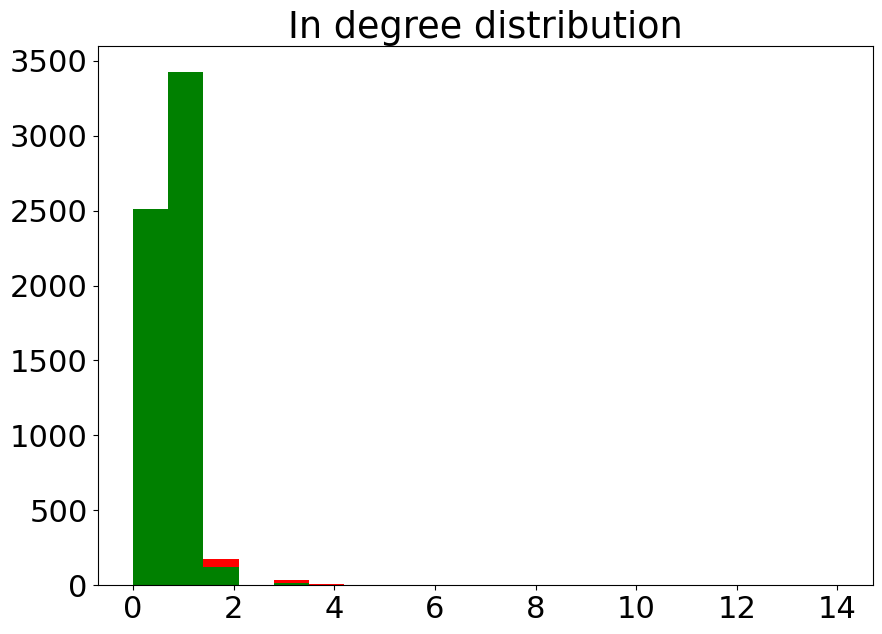

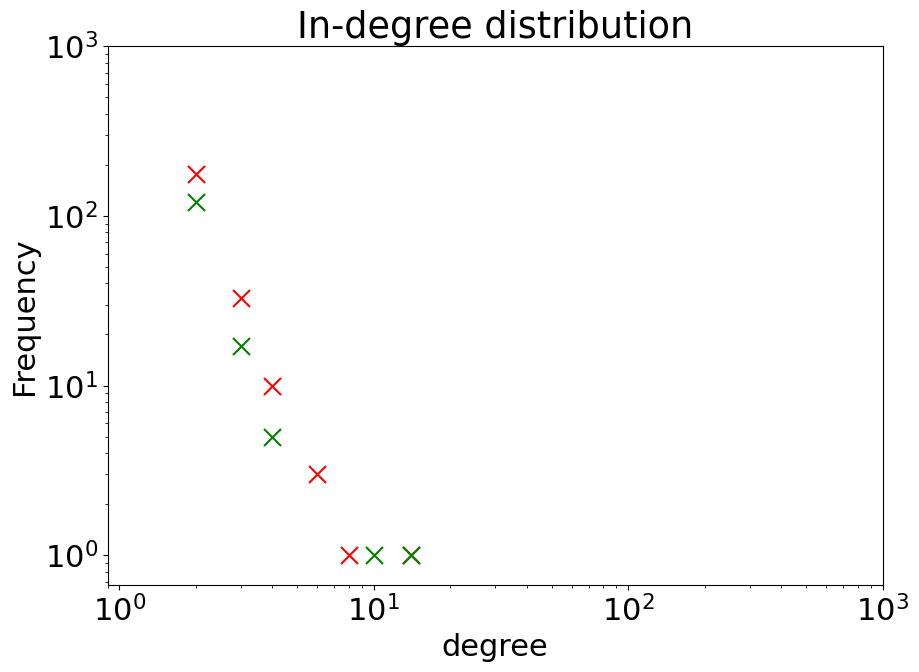

Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


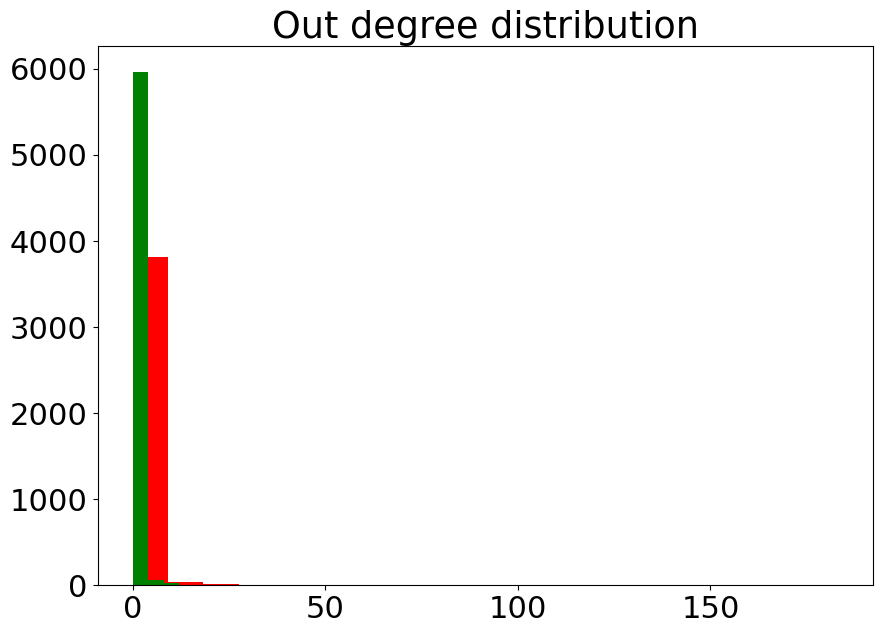

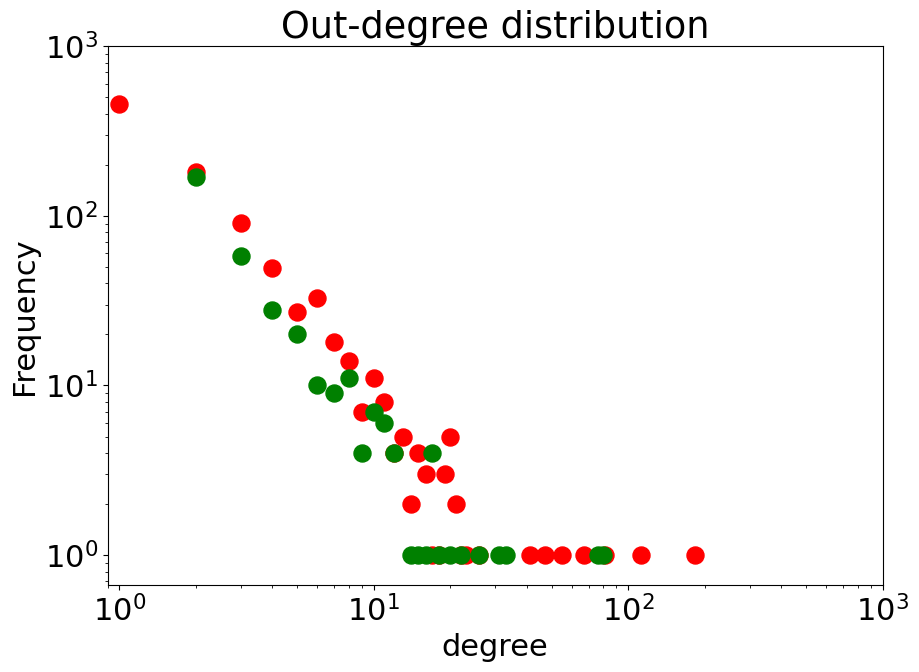

In [69]:
fig_size= [10,7]
plt.rcParams.update({'font.size': 22, "figure.figsize": fig_size})

#Histogram of in-degrees
plt.hist(dict(in_degrees_fraud()).values(), bins=20, density=False, color='red')
plt.hist(dict(in_degrees_nonfraud()).values(), bins=20, density=False,color='green')
plt.title('In degree distribution')
plt.show()

#Plot log-log of in-degree distribution
plt.yscale('log') 
plt.xscale('log') 

in_degree_fraud_counts = dict(collections.Counter(dict(in_degrees_fraud()).values()))
in_degree_nonfraud_counts = dict(collections.Counter(dict(in_degrees_nonfraud()).values()))

#Create scatter plot with degree on x-axis and counts on y-axis
plt.scatter(in_degree_fraud_counts.keys(), in_degree_fraud_counts.values(), c='r', marker='x', s=150)
plt.scatter(in_degree_nonfraud_counts.keys(), in_degree_nonfraud_counts.values(), c='g', marker='x', s=150)
plt.xlim((.9, 1e3)) #set x axis limits
plt.ylim((0, 1e3)) #set y axis limits
plt.xlabel('degree')
plt.ylabel('Frequency')
plt.title('In-degree distribution')
plt.show()

data_nonfraud = np.array(list(in_degree_nonfraud_counts.values()),dtype=np.float32)
fit_nonfraud = powerlaw.Fit(data_nonfraud)
data_fraud = np.array(list(in_degree_fraud_counts.values()),dtype=np.float32)
fit_fraud = powerlaw.Fit(data_fraud)

#Histogram of out-degrees
plt.hist(dict(out_degrees_fraud()).values(), bins=20, density=False, color='red')
plt.hist(dict(out_degrees_nonfraud()).values(), bins=20, density=False, color='green')
plt.title('Out degree distribution')
plt.show()

#Plot log-log of in-degree distribution
plt.yscale('log') 
plt.xscale('log') 

out_degree_fraud_counts = dict(collections.Counter(dict(out_degrees_fraud()).values())) 
out_degree_nonfraud_counts = dict(collections.Counter(dict(out_degrees_nonfraud()).values())) 

#Create scatter plot with degree on x-axis and counts on y-axis 
plt.scatter(out_degree_fraud_counts.keys(), out_degree_fraud_counts.values(), c='r', marker='o', s=150)
plt.scatter(out_degree_nonfraud_counts.keys(), out_degree_nonfraud_counts.values(), c='g', marker='o', s=150)
plt.xlim((.9, 1e3)) #set x axis limits
plt.ylim((0, 1e3)) #set y axis limits
plt.xlabel('degree')
plt.ylabel('Frequency')
plt.title('Out-degree distribution')
plt.show()

#### network visualisation

In [70]:
# define edges 
df_edges = paymaya_df[['source_name','target_name','txn_amount']]

# create network 
G_pay = nx.from_pandas_edgelist(df_edges, source = 'source_name', target = 'target_name', edge_attr = 'txn_amount', create_using=nx.DiGraph())


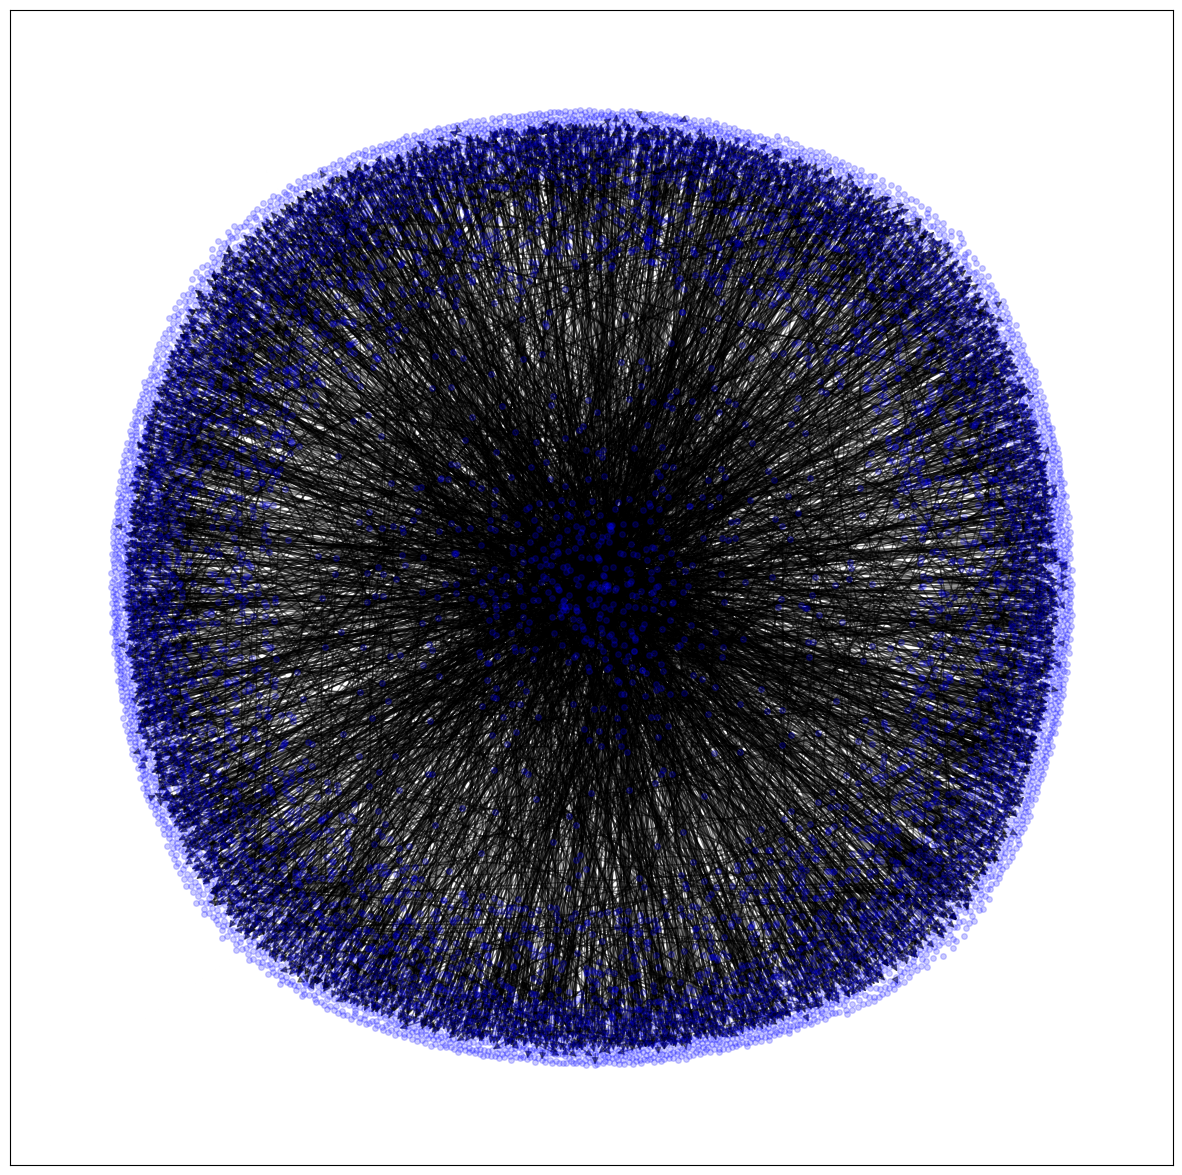

In [71]:
plt.figure(figsize=(15,15)) 
# create the layout 
pos = nx.spring_layout(G_pay)

# draw the nodes and the edges (all)
nx.draw_networkx_nodes(G_pay,pos,node_color='b',alpha=0.2,node_size=16)
nx.draw_networkx_edges(G_pay,pos,alpha=0.5);
